# Multi-Arm Bandit Pair Solutions

## Question 1
Fill in the code stubs in `banditstrategy.py`

### Epsilon-Greedy
* **Explore** with some probability $\epsilon$ (often 10%)
* All other times we will **exploit** (i.e. choose the bandit with the best performance so far)
* After we choose a given bandit we update the performance based on the result.

```python
def _epsilon_greedy(self):
    '''
    Pick a bandit uniformly at random epsilon percent of the time.
    Otherwise pick the bandit with the best observed proportion of winning

    Returns
    --------
    int : index of the winning bandit
    '''
    # Set default value of epsilon if not provided in init
    epsilon = self._kwargs.get('epsilon', 0.1)

    # Verify that we have attempted each bandit at least once
    if self.trials.min() == 0:
        return np.argmin(self.trials)
    if random.random() < epsilon:
        # Exploration
        return np.random.randint(len(self.bandits))
    else:
        return np.argmax(self.wins / self.trials)
```

### Softmax
For the softmax algorithm we will choose the bandit randomly in proportion to its estimated value.  For example, the proportion that bandit $A$ is chosen out of bandits $A$, $B$, and $C$ is given by...

$$\frac{e^{p_A/\tau}}{e^{p_A/\tau} + e^{p_B/\tau} + e^{p_C/\tau}}$$

$\tau$ is a choosen parameter that controls the 'randomness' of the choice, usually around 0.001

**NOTE**: Setting $\tau$ at 0.001 will cause an underflow error!  Thus the default is set to 0.01

```python
def _softmax(self):
    ''' Pick an bandit according to the Boltzman Distribution

    Returns
    --------
    int : index of the winning bandit
    '''
    # Set default value of tau if not provided in init
    tau = self._kwargs.get('tau', 0.01)

    # Verify that we have attempted each bandit at least once
    if self.trials.min() == 0:
        return np.argmin(self.trials)

    mean = self.wins / self.trials
    scaled = np.exp(mean / tau)
    probs = scaled / np.sum(scaled)
    return np.random.choice(range(0, len(self.bandits)), p=probs)
```

### UCB1 (Upper Confidence Bound)
For the UCB1 algorithm we will choose whichever bandit that has the largest value.  The value associated with bandit $A$ would be given by...

$$p_A + \sqrt{\frac{2 log N}{n_A}}$$

* $p_A$ = the conversion rate of bandit $A$
* $n_A$ = number of times bandit $A$ has been played
* $N$ = total number of times any bandit has been played

```python
def _ucb1(self):
    ''' Pick the bandit according to the UCB1 strategy

    Returns
    --------
    int : index of the winning bandit
    '''
    # Verify that we have attempted each bandit at least once
    if self.trials.min() == 0:
        return np.argmin(self.trials)

    means = self.wins / self.trials
    confidence_bounds = np.sqrt((2. * np.log(self.N)) / self.trials)
    upper_confidence_bounds = means + confidence_bounds
    return np.argmax(upper_confidence_bounds)
```

### Bayesian Bandit
The Bayesian bandit algorithm involves modeling each of our bandits with a beta distribution with the following shape parameters:

* $\alpha$ = 1 + number of times bandit has won
* $\beta$ = 1 + number of times bandit has lost

We will then take a random sample from each bandit's distribution and choose the bandit with the highest value.

```python
def _bayesian_bandit(self):
    '''
    Randomly sample from a beta distribution for each bandit and pick
    the one with the largest value

    Returns
    --------
    int : index of the winning bandit
    '''
    samples = [np.random.beta(a=1 + wins, b=1 + trials - wins)
               for wins, trials in zip(self.wins, self.trials)]
    return np.argmax(samples)
```

## Question 2

See how many wins you have of the 1000 trials using each of the six strategies (two already implemented) with the starting bandits given above.

Try running it again with all of these values and see how different each algorithm does with respect to total number of wins in 1000 rounds.

```
[0.1, 0.1, 0.1, 0.1, 0.9]
[0.1, 0.1, 0.1, 0.1, 0.12]
[0.1, 0.2, 0.3, 0.4, 0.5]
```

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from bandits import Bandits
from banditstrategy import BanditStrategy
# Make plots look nice
plt.style.use('ggplot')

In [2]:
def sample_bandits(bandit_probs, choice_funcs, num_trials=1000, seed=42):
    ''' Sample bandits a give number of times with every choice function
    Print out the resulting number of wins for each choice strategy

    Parameters
    -----------
    bandit_probs : Array of floats (0 to 1)
        Indicates the underlying bandit probabilites
    choice_funcs : Array or List of str
        str indicating which choice functions to simulate
    num_trials : int (default=1000)
        Number of trials to conduct
    seed : int or None (default=42)
        Number to seed our BanditStrategy with for reproducibility
    '''
    print('True Bandit Probabilities: {}'.format(bandit_probs))
    for func in choice_funcs:
        bandits = Bandits(bandit_probs)
        strat = BanditStrategy(bandits, func, seed)
        strat.sample_bandits(num_trials)
        print("\t{} wins with {}".format(strat.wins.sum(), func))
    print('\n')

This `sample_bandits` function makes it easy for us to quickly sample a given list of choice functions against a list of bandit probabilities.  This function also allows you to easily alter the number of trials (`num_trials`) as well as the random seed (`seed`) for reproducibility 

In [20]:
prob = round(float(1.0/12), 2)
bandit_probs = [[prob] * 12 for i in range(2)]
bandit_probs

[[0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08],
 [0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08]]

In [21]:
choice_functions = ['max_mean', 'random_choice',
                    'epsilon_greedy', 'softmax', 'ucb1', 'bayesian_bandit']

for probs in bandit_probs:
    sample_bandits(probs, choice_functions)

True Bandit Probabilities: [0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08]
	82.0 wins with max_mean
	84.0 wins with random_choice
	89.0 wins with epsilon_greedy
	74.0 wins with softmax
	82.0 wins with ucb1
	82.0 wins with bayesian_bandit


True Bandit Probabilities: [0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08]
	82.0 wins with max_mean
	84.0 wins with random_choice
	89.0 wins with epsilon_greedy
	74.0 wins with softmax
	82.0 wins with ucb1
	82.0 wins with bayesian_bandit




In [3]:
bandit_probs = [[0.1, 0.1, 0.1, 0.1, 0.9],
                [0.1, 0.1, 0.1, 0.1, 0.12],
                [0.1, 0.2, 0.3, 0.4, 0.5]]
choice_functions = ['max_mean', 'random_choice',
                    'epsilon_greedy', 'softmax', 'ucb1', 'bayesian_bandit']

for probs in bandit_probs:
    sample_bandits(probs, choice_functions)

True Bandit Probabilities: [0.1, 0.1, 0.1, 0.1, 0.9]
	897.0 wins with max_mean
	263.0 wins with random_choice
	843.0 wins with epsilon_greedy
	894.0 wins with softmax
	851.0 wins with ucb1
	879.0 wins with bayesian_bandit


True Bandit Probabilities: [0.1, 0.1, 0.1, 0.1, 0.12]
	108.0 wins with max_mean
	109.0 wins with random_choice
	106.0 wins with epsilon_greedy
	121.0 wins with softmax
	111.0 wins with ucb1
	103.0 wins with bayesian_bandit


True Bandit Probabilities: [0.1, 0.2, 0.3, 0.4, 0.5]
	502.0 wins with max_mean
	319.0 wins with random_choice
	495.0 wins with epsilon_greedy
	502.0 wins with softmax
	434.0 wins with ucb1
	466.0 wins with bayesian_bandit




## Question 3

Use matplotlib to plot the total regret over time of each algorithm. Use the Bandits with these hidden probabilities: `[0.05, 0.03, 0.06]`

In [22]:
def regret(probabilities, choices):
    ''' Calculate the cumulative regret given an array of choices

    Parameters
    -----------
    probabilities : Array of floats (0 to 1)
        Indicating the underlying bandit probabilites
    choices : Array of int
        ints indicating which bandit was chosen at each round

    Returns
    --------
    Array of floats of the cumulative regret
    '''
    p_opt = np.max(probabilities)
    return np.cumsum(p_opt - probabilities[choices])


def plot_regret(bandit_probs, choice_funcs, num_trials=1000, seed=42):
    ''' Plots the cumulative regret for each choice function on single plot

    Parameters
    -----------
    bandit_probs : Array of floats (0 to 1)
        Indicates the underlying bandit probabilites
    choice_funcs : Array or List of str
        str indicating which choice functions to simulate
    num_trials : int (default=1000)
        Number of trials to conduct
    seed : int or None (default=42)
        Number to seed our BanditStrategy with for reproducibility

    Returns
    --------
    None
    Use plt.show() to view the resulting plot or plt.savefig() to save the plot
    '''
    # Create our figure object and axis
    fig, ax = plt.subplots(figsize=(10, 8))

    for func in choice_funcs:
        bandits = Bandits(bandit_probs)
        strat = BanditStrategy(bandits, func, seed)
        strat.sample_bandits(num_trials)
        bandit_regret = regret(bandit_probs, strat.choices.astype(int))
        ax.plot(bandit_regret, label=func)

    ax.legend(loc='best')
    ax.set_xlabel('Number of Trials')
    ax.set_ylabel('Regret')
    ax.set_title('Probabilities: {}, Seed: {}'.format(str(bandit_probs), seed))

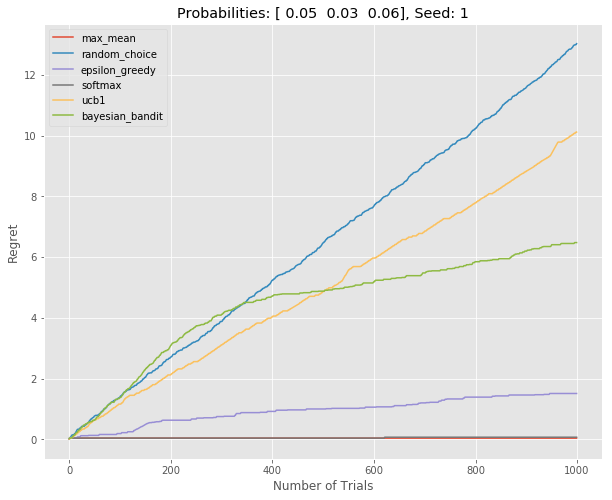

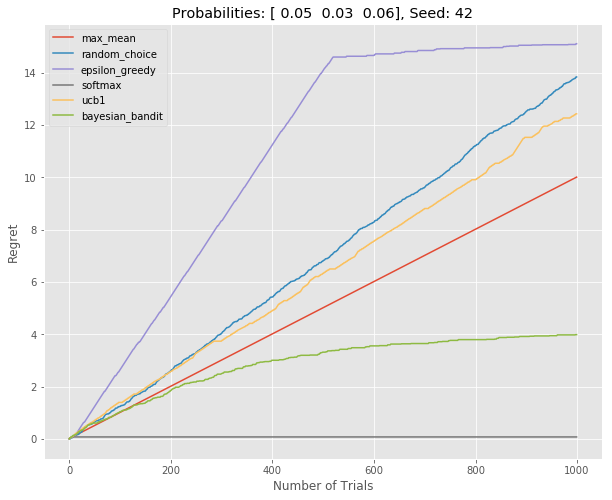

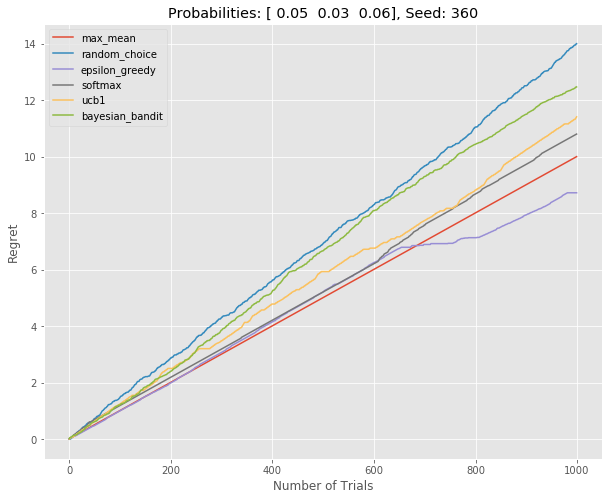

In [23]:
p_array = np.array([0.05, 0.03, 0.06])

# Let's try with a variety of random seeds
seeds = [1, 42, 360]
for seed in seeds:
    plot_regret(p_array, choice_functions, seed=seed)

As we can see above, the regret of a given choice function can be **heavily** influenced by the random seed that has been set.  In fact, if we set `seed=1` then the `max_mean` choice function happens to choose the optimal bandit and goes with that every single time.

## Question 4

Now plot the percentage of time the optimal bandit was chosen over time.

In [24]:
def optimal_percent(probabilities, choices):
    ''' Calculate the percentage of optimal bandit choice over each iteration

    Parameters
    -----------
    probabilities : Array of floats (0 to 1)
        Indicating the underlying bandit probabilites
    choices : Array of int
        ints indicating which bandit was chosen at each round

    Returns
    --------
    Array of floats (0 to 1) indicating the percentage of optimal choice at any
        given choice iteration
    '''
    p_opt = np.max(probabilities)
    count_correct = np.cumsum(probabilities[choices] == p_opt)
    # Divide by the array [1, 2, ...] to get the average from the totals
    return count_correct / np.arange(1, len(choices) + 1).astype(float)


def plot_optimal_percent(bandit_probs, choice_funcs, num_trials=1000, seed=42):
    '''
    Plots the percentage of optimal bandit choice for each choice function on
    single plot

    Parameters
    -----------
    bandit_probs : Array of floats (0 to 1)
        Indicates the underlying bandit probabilites
    choice_funcs : Array or List of str
        str indicating which choice functions to simulate
    num_trials : int (default=1000)
        Number of trials to conduct
    seed : int or None (default=42)
        Number to seed our BanditStrategy with for reproducibility

    Returns
    --------
    None
    Use plt.show() to view the resulting plot or plt.savefig() to save the plot
    '''
    # Create our figure object and axis
    fig, ax = plt.subplots(figsize=(10, 8))

    for func in choice_funcs:
        bandits = Bandits(bandit_probs)
        strat = BanditStrategy(bandits, func, seed)
        strat.sample_bandits(num_trials)
        bandit_opt = optimal_percent(bandit_probs, strat.choices.astype(int))
        ax.plot(bandit_opt, label=func)

    ax.legend(loc='best')
    ax.set_xlabel('Number of Trials')
    ax.set_ylabel('Percent Correct')
    ax.set_title('Probabilities: {}, Seed: {}'.format(str(bandit_probs), seed))

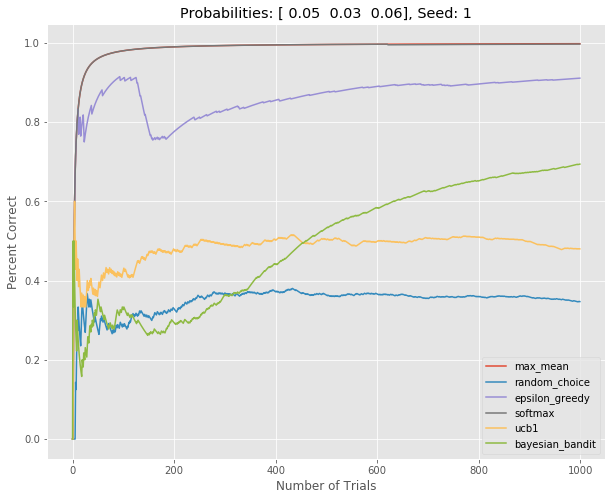

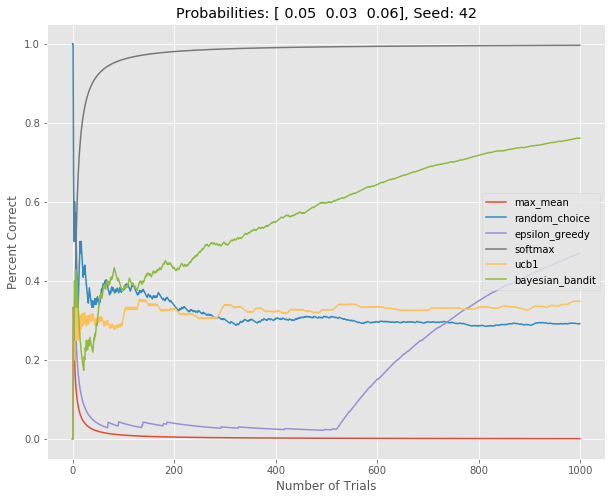

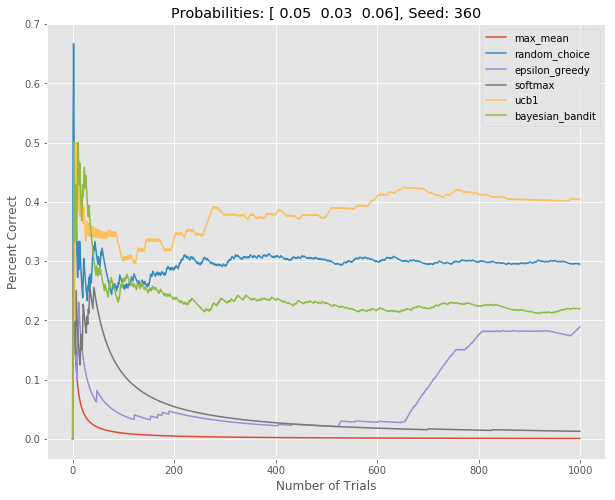

In [25]:
# Let's again plot using a variety of random seeds
for seed in seeds:
    plot_optimal_percent(p_array, choice_functions, seed=seed)

Because we chose the same 3 random seeds, these plots of how often we chose the optimal bandit for a given choice function coorespond with the plots above showing the regret of each choice function.